# Selective Synaptic Dampening (SSD)

https://arxiv.org/abs/2308.07707

In [1]:
import copy
import gc
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = "./"
sys.path.append(path)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/unlearning"

In [5]:
from constants import *
from utils import (
    set_seed,
    train_data,
    val_data,
    train_loader,
    val_loader,
    fine_labels,
    invTrans,
)
from models import get_model_and_optimizer

set_seed()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
MODEL_NAME = f"CNN_CIFAR_100_ORIGINAL"
print("Model Name:", MODEL_NAME)

Model Name: CNN_CIFAR_100_ORIGINAL


# Setup

In [7]:
target_class = 23
fine_labels[target_class]

'cloud'

In [8]:
def eval(model, val_loader, criterion, device):
    val_losses = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for i, (img, label) in enumerate(val_loader):

            img, label = img.to(device), label.to(device)
            out = model(img)

            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())

            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / ((len(val_loader) - 1) * BATCH_SIZE + label.size(0))

    return val_loss, val_acc

In [9]:
forget_idx = np.where(np.array(train_data.targets) == target_class)[0]
forget_mask = np.zeros(len(train_data.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

forget_data = torch.utils.data.Subset(train_data, forget_idx)
retain_data = torch.utils.data.Subset(train_data, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_data, batch_size=BATCH_SIZE, shuffle=False
)
retain_loader = torch.utils.data.DataLoader(
    retain_data, batch_size=BATCH_SIZE, shuffle=False
)

In [10]:
LOAD_EPOCH = 100

model, optimizer = get_model_and_optimizer()
model.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["model_state_dict"]
)
optimizer.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["optimizer_state_dict"]
)
model.to(device)
print("Model and optimizer loaded")

Model and optimizer loaded


In [11]:
criterion = nn.CrossEntropyLoss()

# Utils

In [12]:
def calc_param_importances(model, loader, optimizer, criterion):

    param_importances = dict(
        [
            (name, torch.zeros_like(p, device=p.device))
            for name, p in model.named_parameters()
        ]
    )

    for step, (img, label) in enumerate(loader):
        # img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, label)
        loss.backward()

        for (_, p), (_, imp) in zip(
            model.named_parameters(), param_importances.items()
        ):
            if p.grad is not None:
                imp.data += p.grad.data.clone().pow(2)

    param_importances = {
        _: imp / float(len(loader)) for _, imp in param_importances.items()
    }

    return param_importances

In [13]:
def apply_ssd(
    model, full_importances, forget_importances, alpha=10, lambda_dampen=1, thresh=1e-5
):
    # α and λ chosen for CIFAR as from paper

    ## use alpha to find specialized parameters, update via multiplication of β, where
    ## β = min((λD / D_f), 1)
    ## `thresh` is not from the paper——requires forget importances to be above a certain magnitude threshold to be applied
    with torch.no_grad():
        for (_, p), (_, full_imp), (_, forget_imp) in zip(
            model.named_parameters(),
            full_importances.items(),
            forget_importances.items(),
        ):
            # compute indices of specialized parameters
            # (i.e. if full imp is 0 then any nonzero forget imp will normally be applied)
            spec_idx = torch.where(
                (forget_imp > (alpha * full_imp)) & (forget_imp > thresh)
            )
            # compute dampening factor β
            beta = (lambda_dampen * full_imp) / forget_imp
            # prepare param update factor
            delta = beta[spec_idx]
            delta[torch.where(delta > 1)] = 1  # bound by 1
            # apply updates
            p[spec_idx] *= delta

            pct_params_changed = (len(spec_idx[0]) / p.numel()) * 100
            print(
                f"Layer {_ : <20} | Params modified: {len(spec_idx[0]) : <5} | Percent modified: {pct_params_changed: <.3f}"
            )

# Driver code

In [14]:
model.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm2d_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2d_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=100, bias=True)
)

In [15]:
# full_importances = calc_param_importances(model, train_loader, optimizer, criterion)
# # takes a long time, ~15 min
# torch.save(full_importances, f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_full_importances.pt")

In [16]:
full_importances = torch.load(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_full_importances.pt",
    map_location=device,
)

In [17]:
del train_data, train_loader
gc.collect()

38

In [18]:
# forget_importances = calc_param_importances(model, forget_loader, optimizer, criterion)
# torch.save(forget_importances, f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_forget_importances.pt")

In [19]:
forget_importances = torch.load(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_forget_importances.pt",
    map_location=device,
)

In [20]:
# forget and val data accuracy
eval(model, forget_loader, criterion, device)[1], eval(
    model, val_loader, criterion, device
)[1]

(0.875, 0.5726)

In [21]:
apply_ssd(
    model, full_importances, forget_importances, alpha=10, lambda_dampen=1, thresh=1e-4
)

Layer conv1.weight         | Params modified: 0     | Percent modified: 0.000
Layer conv1.bias           | Params modified: 0     | Percent modified: 0.000
Layer conv2.weight         | Params modified: 27    | Percent modified: 0.037
Layer conv2.bias           | Params modified: 0     | Percent modified: 0.000
Layer conv3.weight         | Params modified: 292   | Percent modified: 0.099
Layer conv3.bias           | Params modified: 2     | Percent modified: 0.781
Layer conv4.weight         | Params modified: 3964  | Percent modified: 0.336
Layer conv4.bias           | Params modified: 1     | Percent modified: 0.195
Layer batchnorm2d_1.weight | Params modified: 0     | Percent modified: 0.000
Layer batchnorm2d_1.bias   | Params modified: 0     | Percent modified: 0.000
Layer batchnorm2d_2.weight | Params modified: 3     | Percent modified: 0.586
Layer batchnorm2d_2.bias   | Params modified: 1     | Percent modified: 0.195
Layer fc1.weight           | Params modified: 1282  | Percent mo

In [22]:
# forget and val data accuracy
eval(model, forget_loader, criterion, device)[1], eval(
    model, val_loader, criterion, device
)[1]

(0.0, 0.5558)

In [23]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
    },
    f"{path}/checkpoints/{MODEL_NAME}_UNLEARNED_SSD.pt",
)

## visualization

In [250]:
# use shuffle for more interesting results
val_viz_loader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True
)
forget_viz_loader = torch.utils.data.DataLoader(
    forget_data, batch_size=BATCH_SIZE, shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

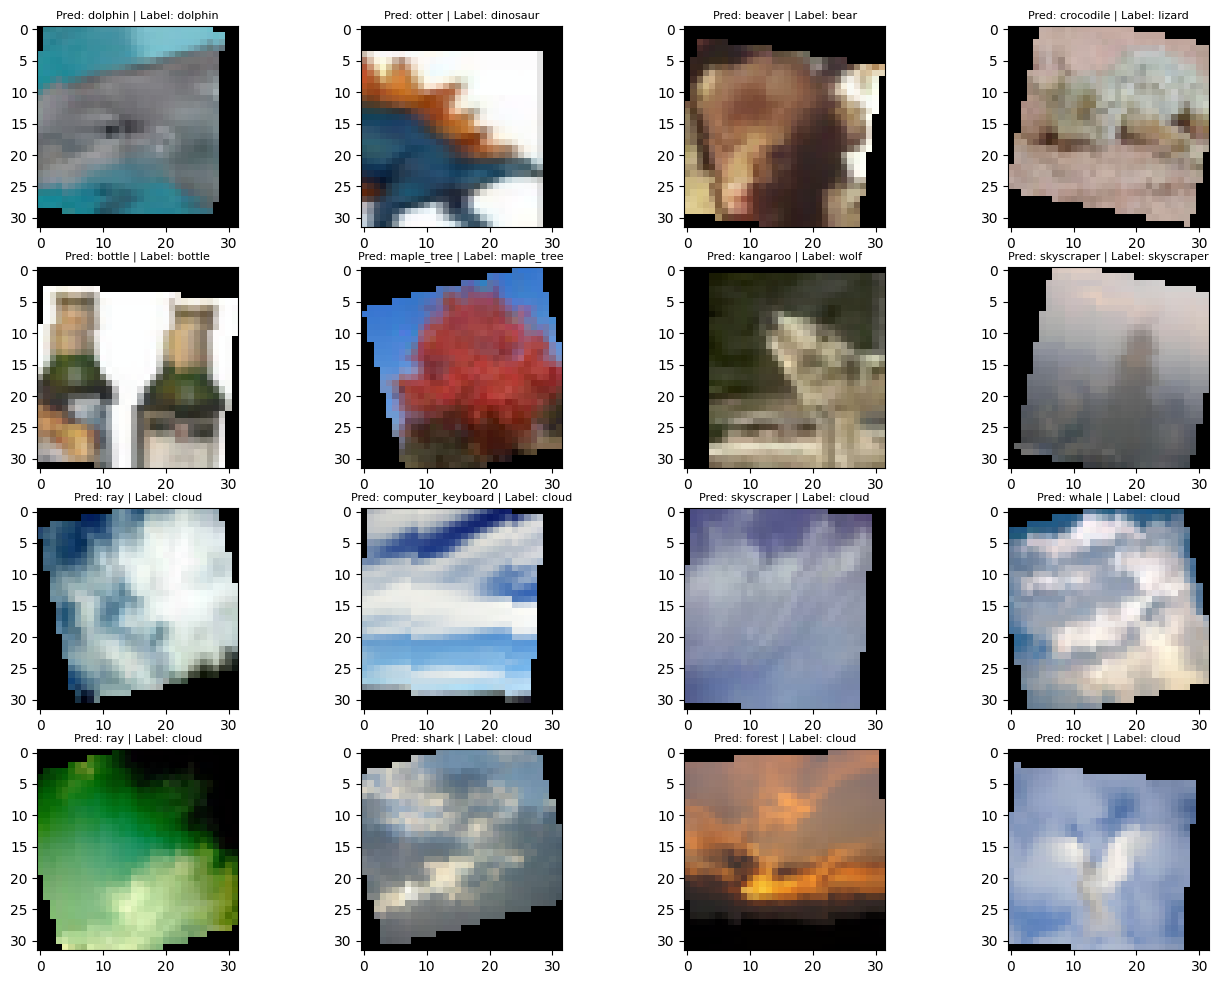

In [251]:
model.eval()
with torch.no_grad():
    # choose one batch from val and one batch from forget
    for (val_img, val_label), (forget_img, forget_label) in zip(
        val_viz_loader, forget_viz_loader
    ):
        viz_img, viz_label = torch.cat([val_img, forget_img]), torch.cat(
            [val_label, forget_label]
        )
        viz_img, viz_label = viz_img.to(device), viz_label.to(device)
        out = model(viz_img)
        pred = out.argmax(dim=-1)
        break

# assumes BATCH_SIZE=8
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i, ax in enumerate(axes.ravel()):
    ax.set_title(
        f"Pred: {fine_labels[pred[i]]} | Label: {fine_labels[viz_label[i]]}", fontsize=8
    )
    ax.imshow(invTrans(viz_img[i]).cpu().permute(1, 2, 0))
plt.show()

# further work:

If we break val into validation and test data, we could do optuna HPO on alpha, lambda_dampen, and thresh using a custom objective (e.g. maximize validation performance - weight * forget performance)